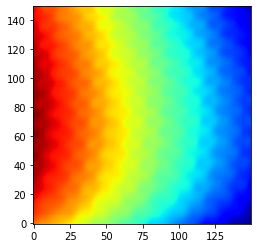

In [1]:
import nanonispy as nap
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import *
import spiepy, spiepy.demo
from skimage.feature import peak_local_max
nm_to_m = 10**(-9)
Im = 1j
filename = 'C:/Users/yg/Desktop/数据分析/CsV3Sb5/Grid Spectroscopy-Cr-166-120meV-mapping--002.3ds'
grid = nap.read.Grid(filename)
size_x = grid.header['size_xy'][0]
size_y = grid.header['size_xy'][1]
lines = grid.header['dim_px'][0]
points = grid.header['dim_px'][1]
nm_to_m = 10**(-9)
im = grid.signals['topo']
fig, ax = plt.subplots()
ax.imshow(im, cmap=plt.cm.jet, origin='lower')
plt.show()

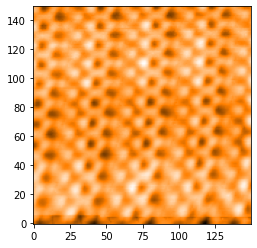

In [2]:
# 法二:high order plane fit without masking
order = 3
im = im.astype('float')
lines, points = im.shape
x_fit = np.arange(points)
y_fit = np.arange(lines)
im_plane_x, im_plane_y = np.meshgrid(x_fit.astype('float'), y_fit.astype('float'))
y = im_plane_y.ravel()
x = im_plane_x.ravel()
z = im.ravel()
import itertools
ij = itertools.product(list(range(order+1)),list(range(order+1)))
ncols = (order + 1)**2
g = np.zeros((x.size,ncols))  # g = np.zeros((x.shape[0],ncols))
for k, (i,j) in enumerate(ij):
    g[:,k] = (x**i)*(y**j)
coeff = np.linalg.lstsq(g,z,rcond=-1)[0]
offset = np.zeros_like(z)
ij = itertools.product(list(range(order+1)),list(range(order+1)))
for k, (i,j) in enumerate(ij):
    offset += coeff[k] * g[:,k]
z -= offset
im_new = z.reshape(im.shape)
palette = spiepy.NANOMAP
palette.set_bad('r',1.0)
fig, ax =plt.subplots()
ax.imshow(im_new, cmap=palette, origin = 'lower')
plt.show()

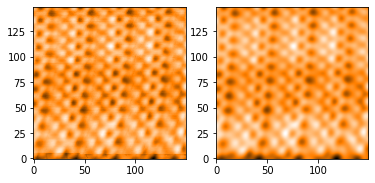

In [3]:
# 局域极值定位
from scipy import ndimage
sigma = 2.0
mode = 'nearest'
im_blur = ndimage.gaussian_filter(input = im_new, sigma = sigma, mode = 'nearest')
fig = plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(im_new, cmap=palette, origin='lower')
ax2 = plt.subplot(122)
ax2.imshow(im_blur, cmap=palette, origin='lower')
plt.show()
a0 = ndimage.maximum_filter(-im_blur, 8) == -im_blur  # 找出谷的位置
a1 = ndimage.maximum_filter(im_blur, 8) == im_blur # 找出峰的位置
edge_mask = np.zeros_like(im, 'bool')
edge_mask[1:-1,1:-1] = True  # edge_mask的边界上都是False而内部都是True
a0 = a0 * edge_mask
a1 = a1 * edge_mask
p = [np.nonzero(a0)]
p.append(np.nonzero(a1)) # p[0],p[1]分别存放谷/峰的位置

In [4]:
import spiepy
# 对局域极值进行mask:mask_by_local_extremes
mask_1, p_1 = spiepy.mask.by_troughs_and_peaks(im, master_mask=None, mult=(0.1,0.1), sigma=2.0) # 源代码,用来与修改后的比较
trough_d = np.mean(im[p[0]])
peak_h = np.mean(im[p[1]])
p2p = peak_h - trough_d
mult = [0.1, 0.1]
mask = (im < trough_d - p2p * mult[0]) | (im > peak_h + p2p * mult[1])

a0 = np.zeros_like(mask, 'bool')
a1 = np.zeros_like(mask, 'bool')
a0[p[0]] = True
a1[p[1]] = True
a0 = a0 * ~mask
a1 = a1 * ~mask
p = [np.nonzero(a0)]
p.append(np.nonzero(a1))
average_dist, index, dists = spiepy.locate._average_minimum_distance(p)
# print(p[0])
# print(p_1)

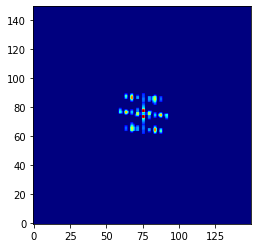

In [5]:
### 漂移校正方法一
## 扣背底之后的图像

## 进行傅里叶变换前的去掉背底
def rm_fft_center_by_real(im: np.array):
    av = np.average(im)
    im_new = im - av
    return im_new
im_new = rm_fft_center_by_real(im=im_new)
# ax2 = plt.subplot(232)
# ax2.imshow(im_new, cmap=plt.cm.jet, origin='lower')

## 进行傅里叶变换
from numpy.fft import *
def fft_max_filter(fft_im, factor:float, size:float):
    fft_max = fft_im.max()
    fft_im_new = fft_im
    fft_bin = np.where(fft_im > factor*fft_max, 1, 0)
    mask_x, mask_y = np.where(fft_bin == 0)
    fft_im_new[mask_x, mask_y] = 0
    fft_im_new = ndimage.maximum_filter(fft_im_new, size)
    return fft_im_new

topo_fft = abs(fftshift(fft2(im_new)))
# ax3 = plt.subplot(233)
# ax3.imshow(topo_fft, cmap=plt.cm.jet, origin='lower')

## 对傅里叶图像进行预处理 max_filter
fft_max = topo_fft.max()
factor = 0.15
size = 2.0
topo_fft_new = fft_max_filter(topo_fft, factor, size)

fig = plt.figure()
ax1 = plt.subplot()
ax1.imshow(topo_fft_new, cmap=plt.cm.jet, origin='lower')
plt.show()


[[64 83]
 [86 67]
 [74 87]
 [76 63]
 [85 83]
 [65 67]]
14.545454545454547
5


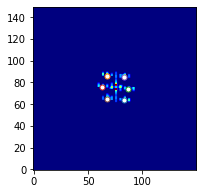

In [12]:
## 找出Bragger Peaks
def find_bragg_peaks(topo_fft:np.array, bp_len:float, thres:float, symmetry:int, min_dist=None):
    theta = np.linspace(0, 2 * np.pi, 2*symmetry+1)
    upper_bound = bp_len + thres
    lower_bound = bp_len - thres
    min_dist = 2 * lower_bound * np.sin(theta[1] / 2)
    center = [topo_fft.shape[1]/2, topo_fft.shape[0]/2]
    if min_dist == None:
        min_distance = round(2 * lower_bound * np.sin(theta[1] / 2))
    else:
        min_distance = round(min_dist)
    coor = peak_local_max(image=topo_fft, min_distance=min_distance)
    bp_coord = []
    for i in range(coor.shape[0]):
        if lower_bound < np.sqrt(((coor[i][0])-center[1])**(2) + ((coor[i][1])-center[0])**(2)) < upper_bound :
            bp_coord.append(coor[i])
    return bp_coord

atom_dist = 5.5 * 10**(-10)
symmetry = 6
thres = 5
bp_len = (2*np.pi/atom_dist) / (2*np.pi/size_x)
bp_coord = find_bragg_peaks(topo_fft, bp_len, thres, symmetry)
bp_coord = np.array(bp_coord)
print(bp_coord)
print(bp_len)
print(thres)
fig = plt.figure(figsize=(4,3))
ax1 = plt.subplot()
ax1.imshow(topo_fft_new, cmap=plt.cm.jet, origin='lower')
for i in range(len(bp_coord)):
    ax1.plot(bp_coord[i][1], bp_coord[i][0], 'o', mfc='#ffffff', ms=5)
plt.show()

In [7]:
# 对Bragg Peak按照角度进行排序
# def sort_bp(bp_coord, im_shape)
im_shape = topo_fft.shape
center = np.array([im_shape[0]/2, im_shape[1]/2])
bp_sort_coord = np.array(sorted(bp_coord-center, key= lambda x:np.arctan2(*x)) + center)
print(bp_sort_coord)

[[65. 67.]
 [64. 83.]
 [74. 87.]
 [85. 83.]
 [86. 67.]
 [76. 63.]]


In [8]:
def gaussian_2D(dim_x, dim_y, cen_x, cen_y, ang, amp, sigma_1, sigma_2, offset):
    xx, yy = np.meshgrid(np.arange(dim_x,dtype='float'),np.arange(dim_y,dtype='float'))
    xx_twist = + (xx-cen_x)*np.cos(ang) + (yy-cen_y)*np.sin(ang)
    yy_twist = - (xx-cen_y)*np.sin(ang) + (yy-cen_y)*np.cos(ang)
    g_mask = offset + amp * np.exp(- xx_twist** (2) / (2 * sigma_1 ** (2)) - yy_twist ** (2) / (2 * sigma_2 ** (2)))
    return g_mask

def FTDCfilter(A:np.array, sigma_1:float, sigma_2:float):
    # 对A进行傅里叶变换之后乘以关于中心对称的高斯分布
    dim_y, dim_x = A.shape
    cen_x, cen_y = (dim_x-1) / 2 , (dim_y-1) / 2
    ang = 0
    sigma_x = sigma_1 * dim_x / 2 * np.pi
    sigma_y = sigma_2 * dim_y / 2 * np.pi
    amp = 1 / (2 * np.pi * sigma_x * sigma_y)
    offset = 0
    g_mask = gaussian_2D(dim_x, dim_y, cen_x, cen_y, ang, amp, sigma_x, sigma_y, offset)
    A_fft = fftshift(fft2(A)) # 是复数
    A_g_fft = A_fft * g_mask
    A_new = ifft2(ifftshift(A_g_fft))
    return A_new

In [17]:
## 进行漂移校正:第一步 获取phasemap
from scipy.signal import convolve2d
# 形参
Im = 1j
# method = 'product_ifft'
# 首先确定两个夹角最接近于90°的bragg peaks
def find_two_bps(bp_coord, im_shape:tuple):
    center = np.array([(im_shape[0]-1)/2, (im_shape[1]-1)/2])
    Q_1 = 2 * np.pi / im_shape[1] * (bp_coord[0] - center)
    Q_vec = 2 * np.pi / im_shape[1] *(bp_coord - center)
    Q_prod = abs(sum((Q_1 * Q_vec).T))
    min_index = np.argmin(Q_prod)
    Q_2 = 2 * np.pi / im_shape[1] * (bp_sort_coord[min_index] - center)
    return Q_1, Q_2

# 然后进行sin,cos乘积
def multi_sin_cos(topo_real:np.array,Q_1,Q_2): # 需要把中心定位在中心
    im_shape = topo_real.shape
    center = np.array([(im_shape[0]-1)/2, (im_shape[1]-1)/2])
    xx, yy = np.meshgrid(np.arange(im_shape[1], dtype='float'),np.arange(im_shape[0], dtype='float'))
    xx -= center[1]
    yy -= center[0]
    A_1s = topo_real * np.sin(Q_1[0]*yy + Q_1[1]*xx)
    A_1c = topo_real * np.cos(Q_1[0]*yy + Q_1[1]*xx)
    A_2s = topo_real * np.sin(Q_2[0]*yy + Q_2[1]*xx)
    A_2c = topo_real * np.cos(Q_2[0]*yy + Q_2[1]*xx)
    return A_1s, A_1c, A_2s, A_2c

from scipy.ndimage import gaussian_filter
# 然后进行高斯卷积,有两种不同的方法:lock_in 或者 convolution
def gauss_mask_by_convolution(A_c:np.array,A_s:np.array, sigma:float):
    im_shape = A_c.shape
    center = np.array([(im_shape[0]-1)/2, (im_shape[1]-1)/2])
    gauss_mask = gaussian_2D(im_shape[1], im_shape[0], center[1], center[0], 0, 1 / (2 * np.pi * sigma**2), sigma, sigma, 0)
#     T = convolve2d(A_c+Im*A_s, gauss_mask, boundary='symm', mode='same')
    Tc = gaussian_filter(input=A_c, sigma=sigma)
    Ts = gaussian_filter(input=A_s, sigma=sigma)
    T = np.zeros_like(A_c, dtype=complex)
    T = Tc + Im * Ts
    phi = np.angle(T)
    mag = np.absolute(T)
    return phi, mag

def gauss_mask_by_product_ifft(A_c:np.array,A_s:np.array, sigma:float):
    T = FTDCfilter(A_c + Im * A_s, sigma, sigma)
    phi = np.angle(T)
    mag = np.absolute(T)
    return phi, mag

def gauss_mask_by_method(A_1c:np.array,A_1s:np.array, A_2c:np.array,A_2s:np.array, sigma:float, method):
    if method == 'convolution':
        phi_1,mag_1 = gauss_mask_by_convolution(A_1c,A_1s, sigma)
        phi_2,mag_2 = gauss_mask_by_convolution(A_2c,A_2s, sigma)
    elif method == 'product_ifft':
        phi_1,mag_1 = gauss_mask_by_product_ifft(A_1c, A_1s, sigma)
        phi_2,mag_2 = gauss_mask_by_product_ifft(A_2c, A_2s, sigma)
    return phi_1, mag_1, phi_2, mag_2

topo_real = im_new
Q_1, Q_2 = find_two_bps(bp_sort_coord, im_shape)
print(Q_1,Q_2)
A_1s, A_1c, A_2s, A_2c = multi_sin_cos(topo_real, Q_1, Q_2)
# print(A_1c)
sigma = 15
method = 'convolution' 
phi_1, mag_1, phi_2, mag_2 = gauss_mask_by_method(A_1c, A_1s, A_2c, A_2s, sigma, method) 

[-0.39793507 -0.31415927] [-0.43982297  0.35604717]
[[-1.05667231 -1.0520079  -1.0427428  ...  1.70169735  1.70584764
   1.70792172]
 [-1.05674576 -1.05208671 -1.0428322  ...  1.70161515  1.70576201
   1.70783436]
 [-1.05689424 -1.05224581 -1.04301228 ...  1.70145731  1.70559746
   1.70766645]
 ...
 [-3.10602746 -3.10428674 -3.10078851 ... -0.10906491 -0.10231111
  -0.09888264]
 [-3.10026843 -3.09853024 -3.09503703 ... -0.10156237 -0.09479136
  -0.0913541 ]
 [-3.09738746 -3.09565054 -3.09215984 ... -0.09781836 -0.09103886
  -0.08759725]]


In [18]:
# 消除相移
# def unwrap_phase(ph, tolerance=None, max_value=None):
    # 统计相移的次数并补上相位差
def phase_jump_correct_by_line(ph_line, tol, maxval, iteration:int):
    dph_line = np.zeros_like(ph_line)
    ph_line_corr = ph_line
    master = False
    count = 0
    while master == False and count < iteration:
        dph_line[1:] = np.diff(ph_line_corr[:])
        dph_line[np.where(np.abs(dph_line) < tol)] = 0
        dph_line[np.where(dph_line < -tol)] = 1
        dph_line[np.where(dph_line > tol)] = -1
        ph_line_corr = (ph_line_corr + maxval * np.cumsum(dph_line))
        if (dph_line == 0).all() == True:
            master = True
        count += 1
    return ph_line_corr

def phase_jump_correct(ph, tol, maxval, iteration=50):
    ph_new = ph
    for i in range(ph.shape[0]):
        ph_line = ph_new[i]
        ph_new[i] = phase_jump_correct_by_line(ph_line, tol, maxval, iteration)
    return ph_new

# ph_line = ph[:,0].T
# 由于行之间的差别比每一行相邻两点的差别要大,因此校正的优先是行,先进行粗调(phase jump),再进行细调(smooth)
max_value = None
tolerance = None
maxval = 2*np.pi if max_value is None else max_value
tol = 0.25*maxval if tolerance is None else tolerance
# phi_1_new = phi_1
# phi_2_new = phi_2

phi_1_new = phase_jump_correct(phi_1, tol, maxval, 1)
phi_2_new = phase_jump_correct(phi_2, tol, maxval, 1)
phi_1_new = phase_jump_correct(phi_1_new.T, tol, maxval, 1)
phi_2_new = phase_jump_correct(phi_2_new.T, tol, maxval, 1)
phi_1_new = phi_1_new.T
phi_2_new = phi_2_new.T

print(phi_1_new)
# tol_new = 0.125 * 2 * np.pi
# maxval = tol_new
# ph_line_new = phase_jump_correct_by_line(ph_line_new, tol_new, maxval)
# print(ph_line_new)


[[-1.92065582 -1.91963874 -1.91760828 ... -0.95174105 -0.95228053
  -0.95255151]
 [-1.92406339 -1.92306046 -1.92105815 ... -0.95599545 -0.95653355
  -0.95680382]
 [-1.93086007 -1.9298853  -1.92793902 ... -0.96452021 -0.96505553
  -0.96532438]
 ...
 [ 0.11160549  0.11015478  0.10727016 ...  0.41717847  0.41536527
   0.4144523 ]
 [ 0.11868398  0.117229    0.11433592 ...  0.42376836  0.42195551
   0.42104276]
 [ 0.12222996  0.12077282  0.11787547 ...  0.42706266  0.42524998
   0.42433733]]


[[ -1.51598813  -0.52102209   0.46899476 ... 143.08457797 144.07782877
  145.07445373]
 [ -1.52123901  -0.52628759   0.46370008 ... 143.07800867 144.07126652
  145.06789503]
 [ -1.53170948  -0.53678722   0.45314222 ... 143.06483565 144.05810742
  145.05474296]
 ...
 [ -4.34225703  -3.34701211  -2.35651975 ... 138.87654663 139.86409366
  140.85778386]
 [ -4.33932138  -3.34407959  -2.35359337 ... 138.87623526 139.86375839
  140.85743641]
 [ -4.33784505  -3.34260485  -2.35212178 ... 138.87608889 139.8636002
  140.85727221]]


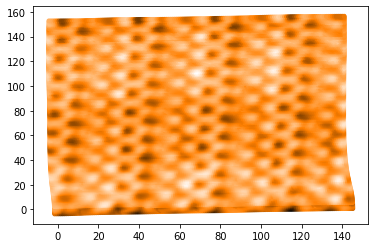

In [13]:
# 得到drift map
def driftmap(phi_1, phi_2, Q_1, Q_2):
    # u_x:u在x方向上的投影,u_2:u在y方向上的投影
    u_x = (phi_1*Q_2[0]-phi_2*Q_1[0]) / (Q_2[0]*Q_1[1]-Q_1[0]*Q_2[1])
    u_y = (phi_1*Q_2[1]-phi_2*Q_1[1]) / (Q_2[1]*Q_1[0]-Q_1[1]*Q_2[0])
    return u_x, u_y

## 真实的原子位置是x+u_x,y+u_y
u_x, u_y = driftmap(phi_1_new, phi_2_new, Q_1, Q_2)
xx, yy = np.meshgrid(np.arange(im_new.shape[1],dtype='float'),np.arange(im_new.shape[0],dtype='float'))
xx_fit = xx - u_x
yy_fit = yy - u_y
# 之后就是与第二种校正一样的方法了.
print(xx_fit)
fig, ax = plt.subplots()
ax.scatter(xx_fit, yy_fit, s=15, c=im_new, cmap=palette)
plt.show()

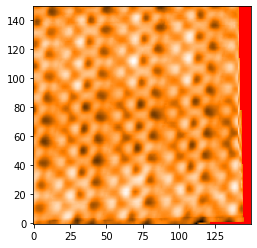

In [14]:
from scipy import interpolate
x_data = xx.flatten()
y_data = yy.flatten()
x_data_fit = xx_fit.flatten()
y_data_fit = yy_fit.flatten()
topo_data = im_new.flatten() 
topo_data_new = interpolate.griddata(points=(x_data_fit, y_data_fit), values=topo_data, xi=(x_data, y_data), method='linear')
im_new_fit = topo_data_new.reshape(im_new.shape)

fig, ax = plt.subplots()
ax.imshow(im_new_fit,cmap=palette,origin='lower')
plt.show()